# https://github.com/must4in3/pix2pix

In [19]:
import tensorflow as tf
import time
import datetime
from src.Image_processing_functions import load, resize, random_crop, normalize, random_jitter 
from src.Image_processing_functions import load_image_train, load_image_test
from src.Image_processing_functions import BUFFER_SIZE, BATCH_SIZE, IMG_WIDTH, IMG_HEIGHT
import os
#import time
#from matplotlib import pyplot as plt
from IPython import display
from src.discriminator_functions import Discriminator, discriminator_loss
from src.generator_functions import downsample, upsample, Generator, generator_loss
#from src.Image_processing_functions import load
from src.training_and_generate_images_functions import generate_images

In [20]:
inp, re = load('imagenes/all_photo/1000_with_mask/1.png')

In [21]:
discriminator = Discriminator()

# Generate Images
Write a function to plot some images during training.

We pass images from the test dataset to the generator.
The generator will then translate the input image into the output.
Last step is to plot the predictions and voila!

*Note: The training=True is intentional here since we want the batch statistics while running the model on the test dataset. If we use training=False, we will get the accumulated statistics learned from the training dataset (which we don't want)*

In [22]:
# Call the load_image_train function that automate the whole process of loading test images.
# Input images 512 pixel 256*2
# Separate real image from input image
# Resize las dos imagenes con el metodo de los NEAREST_NEIGHBOR
# Appy a random_jitter
# Finally normalizing the images to [-1, 1]
train_dataset = tf.data.Dataset.list_files('imagenes/all_photo/1000_with_mask/*.png')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [23]:
test_dataset = tf.data.Dataset.list_files('imagenes/all_photo/1000_with_mask_test/*.png')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

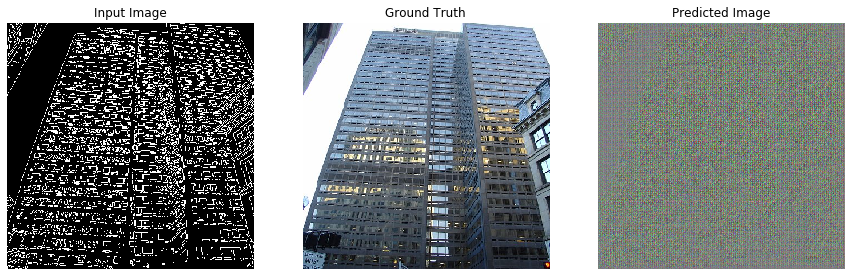

In [24]:
generator = Generator()
for example_input, example_target in test_dataset.take(1):
    generate_images(generator, example_input, example_target)

# Checkpoint

In [25]:
# Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of 
# first-order and second-order moments. According to the paper Adam: A Method for Stochastic Optimization. 
# Kingma et al., 2014, the method is "computationally efficient, has little memory requirement, invariant 
# to diagonal rescaling of gradients, and is well suited for problems that are large in terms of data/parameters".
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [26]:
checkpoint_dir = './training_checkpoints'

In [27]:

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Training
For each example input generate an output.<br>
The discriminator receives the input_image and the generated image as the first input. The second input is the input_image and the target_image.<br>
Next, we calculate the generator and the discriminator loss.<br>
Then, we calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.<br>
Then log the losses to TensorBoard.<br>

In [9]:
EPOCHS = 150

In [10]:
# create a folder with datetime and the training file
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [11]:
@tf.function()
def train_step(input_image, target, epoch):
    '''
    The discriminator receives the input_image and the generated image as the first input. 
    The second input is the input_image and the target_image.
    Next, we calculate the generator and the discriminator loss.
    Then, we calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) 
    and apply those to the optimizer.
    Then log the losses to TensorBoard.
    '''
    # GradientTape = Record operations for automatic differentiation.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)




In [13]:
# definir el checkpoint
def fit(train_ds, epochs, test_ds):
    '''
    The actual training loop:
    Iterates over the number of epochs.
    On each epoch it clears the display, and runs generate_images to show it's progress.
    On each epoch it iterates over the training dataset, printing a '.' for each example.
    It saves a checkpoint every 20 epochs.

    This training loop saves logs you can easily view in TensorBoard to monitor the training progress. 
    Working locally you would launch a separate tensorboard process. In a notebook, if you want to monitor with TensorBoard 
    it's easiest to launch the viewer before starting the training.

    '''
    for epoch in range(epochs):
        start = time.time()

        display.clear_output(wait=True)

        for example_input, example_target in test_ds.take(1):
            generate_images(generator, example_input, example_target)
        print("Epoch: ", epoch)

        # Train
        for n, (input_image, target) in train_ds.enumerate():
            print('.', end='')
            if (n+1) % 100 == 0:
                print()
            train_step(input_image, target, epoch)
        print()

        # saving (checkpoint) the model every 20 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
    checkpoint.save(file_prefix = checkpoint_prefix)

In [14]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

Reusing TensorBoard on port 6006 (pid 7665), started 20:18:50 ago. (Use '!kill 7665' to kill it.)

In [15]:
# Computes the cross-entropy loss between true labels and predicted labels.
#loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [16]:
# Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of 
# first-order and second-order moments. According to the paper Adam: A Method for Stochastic Optimization. 
# Kingma et al., 2014, the method is "computationally efficient, has little memory requirement, invariant 
# to diagonal rescaling of gradients, and is well suited for problems that are large in terms of data/parameters".
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

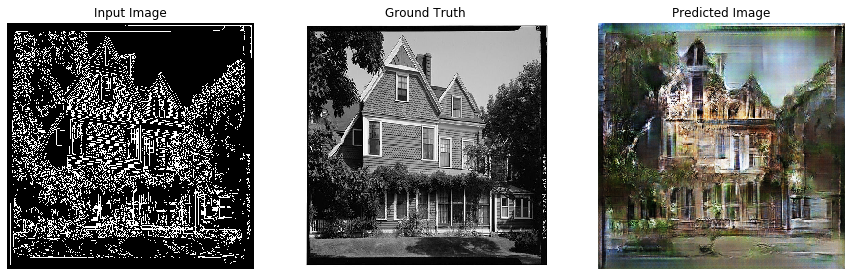

Epoch:  0
....................................................................................................
....................................................................................................
...................................................................

KeyboardInterrupt: 

In [18]:
# training loop
fit(train_dataset, EPOCHS, test_dataset)

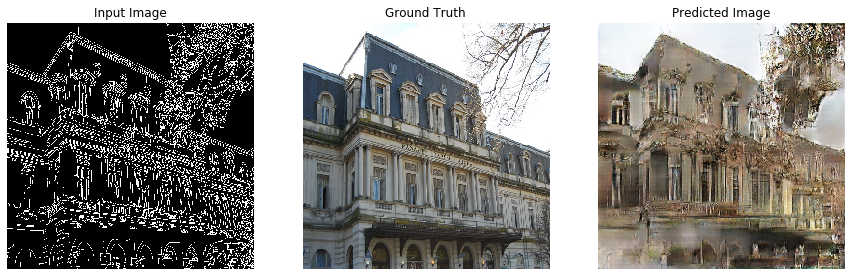

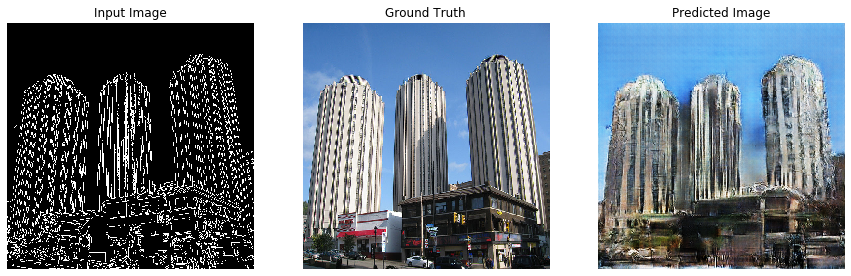

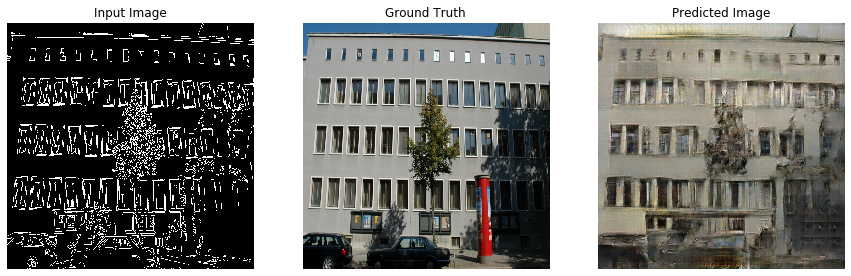

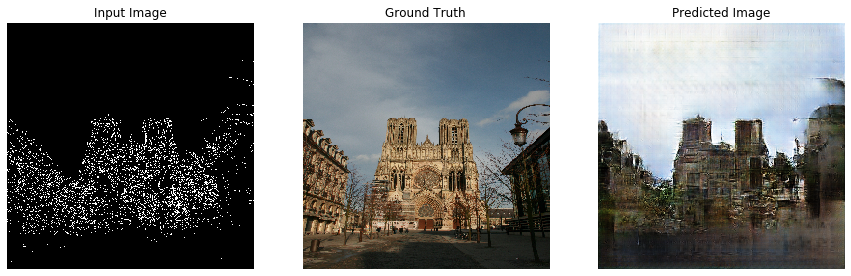

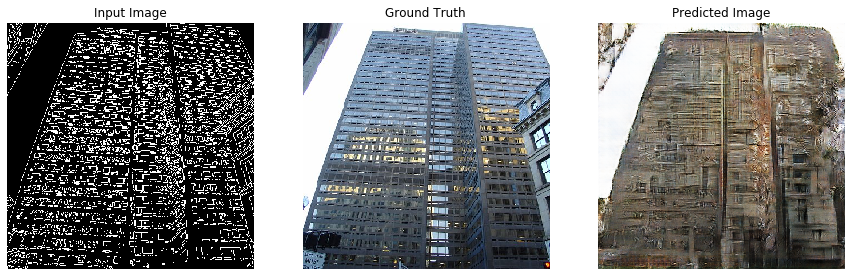

In [19]:
# Run the trained model on a few examples from the test dataset
for inp, tar in test_dataset.take(5):
    generate_images(generator, inp, tar)

In [37]:
test_dataset = tf.data.Dataset.list_files('imagenes/disegni/draw/*.png')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [38]:
ls {training_checkpoints}

ls: cannot access '{training_checkpoints}': No such file or directory


In [39]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

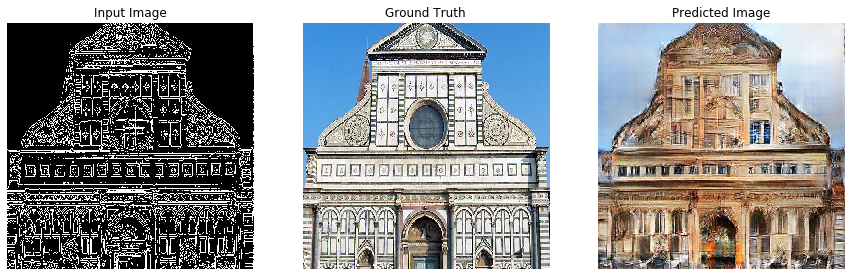

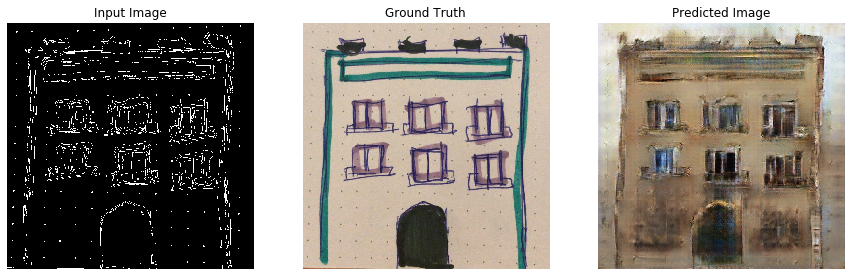

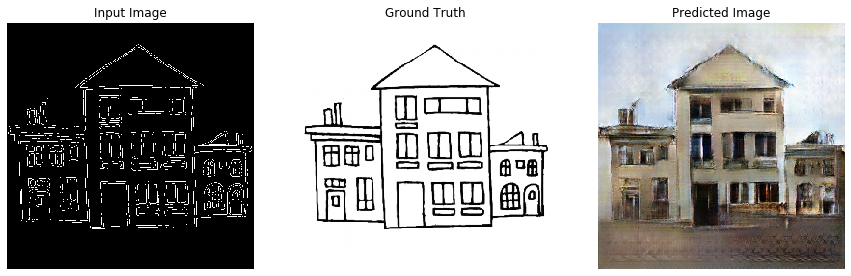

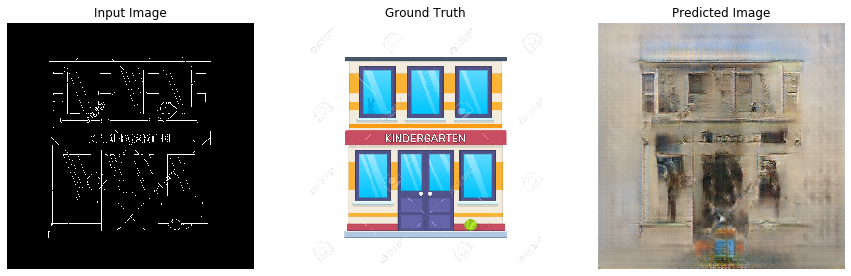

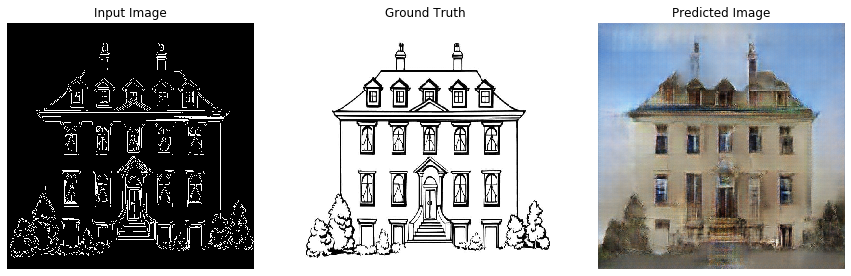

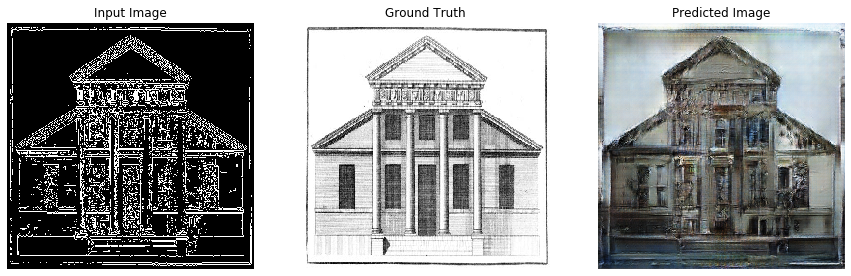

In [41]:
for inp, tar in test_dataset.take(6):
    generate_images(generator, inp, tar)

In [ ]:
#discriminator

In [ ]:
#discriminator.predict

In [ ]:
#from PIL import Image

In [ ]:
#im = Image.open('images/de_convertir/CMP_Facade_Database/CMP_facade_DB_extended/extended/cmp_x0001.png')

In [ ]:
#im.show()

In [ ]:
#im.resize([256,256])

In [ ]:
#im = im.resize([256,256])

In [ ]:
#import numpy as np
#arr= np.array(im)
#arr= np.array([arr])
#arr.shape

In [ ]:
#print(arr)

In [ ]:
#discriminator.predict(arr)